In [149]:
import pandas as pd

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)

In [150]:
X = data[[2,4,10,11,12]]
y = (data[14]==' >50K').astype(int)

In [151]:
X

,2,4,10,11,12
0,77516,13,2174,0,40
1,83311,13,0,0,13
2,215646,9,0,0,40
3,234721,7,0,0,40
4,338409,13,0,0,40
...,...,...,...,...,...
32556,257302,12,0,0,38
32557,154374,9,0,0,40
32558,151910,9,0,0,40
32559,201490,9,0,0,20


1. Выбрать подходящую таблицу данных. Построить и визуализировать дерево решений.


In [152]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=0)

In [153]:
y.value_counts()

14
0    24720
1     7841
Name: count, dtype: int64

In [154]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X, y)

DecisionTreeClassifier(max_depth=3)

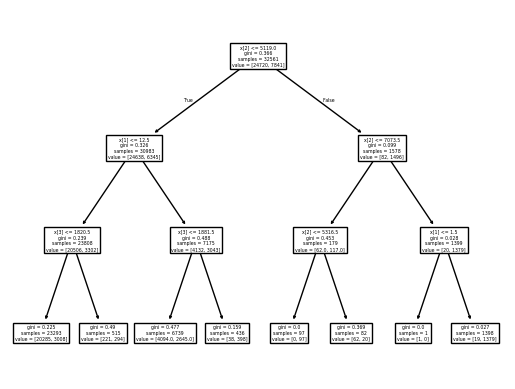

In [155]:
import matplotlib.pyplot as plt

plt.figure()
plot_tree(dtc)
plt.savefig('tree.png', dpi=300)

2. Применить метод градиентного бустинга. Вычислить значимость переменных. Выдать список построенных деревьев.

In [156]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0
                                # ,loss='exponential'
                                ).fit(X,y)

In [157]:
y_pred = clf.predict(X)

In [158]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91     24720
           1       0.86      0.48      0.62      7841

    accuracy                           0.86     32561
   macro avg       0.86      0.73      0.77     32561
weighted avg       0.86      0.86      0.84     32561

0.8568840023340807


In [159]:
import numpy as np

arr = np.array([accuracy_score(y, p) for p in clf.staged_predict(X)])

In [160]:
arr.shape

(1000,)

In [161]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

def cv(X, y, model, n_splits):
    kf = KFold(n_splits)

    acc = []

    for train, test in tqdm(kf.split(X, y), total=n_splits):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
        clf = model.fit(X_train, y_train)
        arr = np.array([accuracy_score(y_test, p) for p in clf.staged_predict(X_test)])
        acc.append(arr)

    return np.array(acc)

In [162]:
model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0)
q_cv = cv(X, y, model, 5)

model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.02, max_depth=6, random_state=0)
q_cv1 = cv(X, y, model, 5)

model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=2, random_state=0)
q_cv2 = cv(X, y, model, 5)


100%|██████████| 5/5 [01:28<00:00, 17.71s/it]


In [163]:
model = GradientBoostingClassifier(n_estimators=700, learning_rate=0.1, max_depth=6, random_state=0)
q_cv3 = cv(X, y, model, 5)

100%|██████████| 5/5 [02:41<00:00, 32.25s/it]


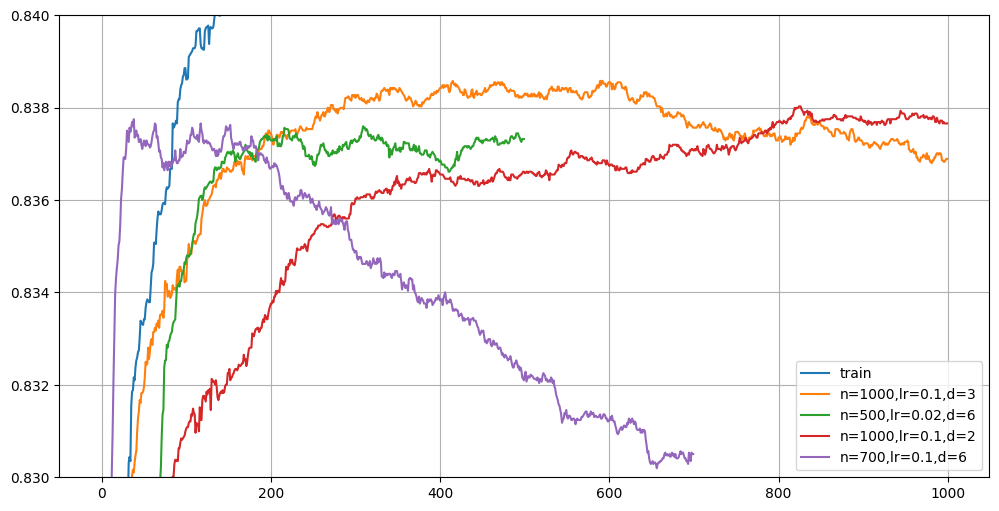

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(arr, label='train')
plt.plot(q_cv.mean(axis=0), label='n=1000,lr=0.1,d=3')
plt.plot(q_cv1.mean(axis=0), label='n=500,lr=0.02,d=6')
plt.plot(q_cv2.mean(axis=0), label='n=1000,lr=0.1,d=2')
plt.plot(q_cv3.mean(axis=0), label='n=700,lr=0.1,d=6')
plt.ylim((0.83, 0.84))
plt.grid()
plt.legend()

In [165]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0, oob_score=True, n_jobs=-1)
rfc.fit(X, y)

RandomForestClassifier(max_depth=3, n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=0)

In [166]:
rfc.oob_score_

0.815976167808114

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm

depth = 5
n_trees = [n for n in range(100, 1000, 10)]

result = {}
cv_scores = []
oob_scores = []

for n in tqdm(n_trees):
    clf = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=0, n_jobs=-1, oob_score=True)
    cv_score = cross_val_score(clf, X, y, cv=5, n_jobs=-1)
    clf.fit(X, y)
    cv_scores.append(cv_score.mean())
    oob_scores.append(clf.oob_score_)

result[f'd_{depth}_cv'] = cv_scores
result[f'd_{depth}_oob'] = oob_scores

100%|██████████| 90/90 [33:44<00:00, 22.50s/it]


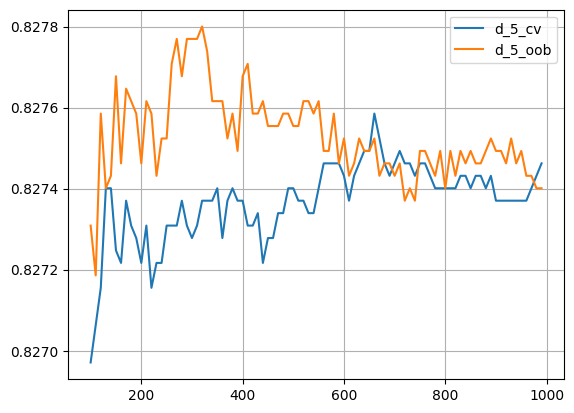

In [178]:
for clf in result.items():
    plt.plot(n_trees, clf[1], label=clf[0])
plt.legend()
plt.grid()

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm

def rf_cv(X, y, n_trees, depth):
    result = {}
    cv_scores = []
    oob_scores = []

    for d in tqdm(depth):
        clf = RandomForestClassifier(n_estimators=n_trees, max_depth=d, random_state=0, n_jobs=-1, oob_score=True)
        cv_score = cross_val_score(clf, X, y, cv=5, n_jobs=-1)
        clf.fit(X, y)
        cv_scores.append(cv_score.mean())
        oob_scores.append(clf.oob_score_)
    
    result[f'n={n_trees}_cv'] = cv_scores 
    result[f'n={n_trees}_oob'] = oob_scores 

    return result

In [170]:
depth = [d for d in range(1, 22, 2)]

In [171]:
rf_cv1 = rf_cv(X, y, 100, depth)

100%|██████████| 11/11 [01:12<00:00,  6.57s/it]


In [172]:
rf_cv2 = rf_cv(X, y, 200, depth)

100%|██████████| 11/11 [02:36<00:00, 14.26s/it]


In [173]:
rf_cv3 = rf_cv(X, y, 300, depth)

100%|██████████| 11/11 [03:45<00:00, 20.52s/it]


(0.825, 0.8338948437937957)

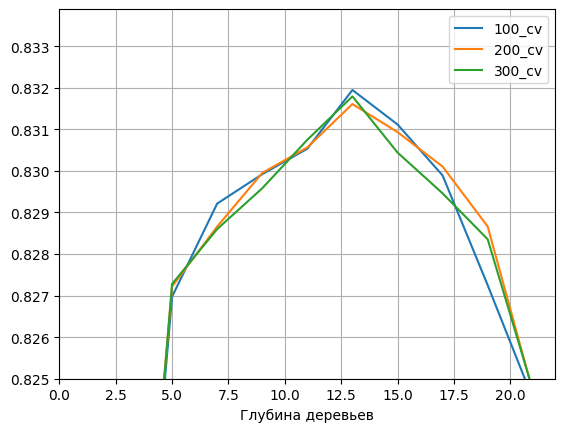

In [174]:
plt.plot(depth, rf_cv1['n=100_cv'], label='100_cv')
plt.plot(depth, rf_cv2['n=200_cv'], label='200_cv')
plt.plot(depth, rf_cv3['n=300_cv'], label='300_cv')
plt.legend()
plt.grid()
plt.xlabel('Глубина деревьев')
plt.ylim(0.825)

(0.825, 0.8356162280028255)

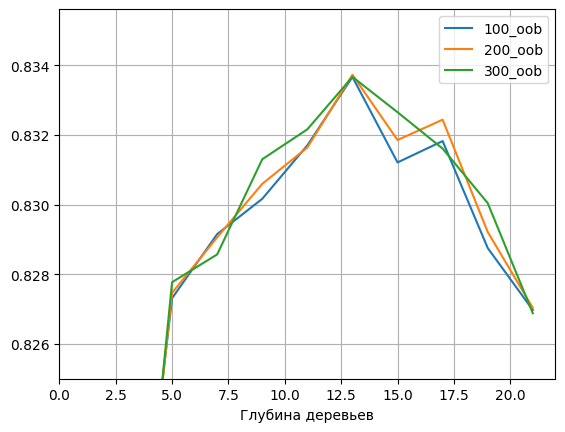

In [175]:
plt.plot(depth, rf_cv1['n=100_oob'], label='100_oob')
plt.plot(depth, rf_cv2['n=200_oob'], label='200_oob')
plt.plot(depth, rf_cv3['n=300_oob'], label='300_oob')
plt.legend()
plt.grid()
plt.xlabel('Глубина деревьев')
plt.ylim(0.825)